###Resume parsing , Screening and Shortlisting System

The key requirements to solve this project are job descriptions and resumes that act as input to the model, which is then passed on to the document reader which extracts all the content from word/PDF documents in the form of text.

After getting the text data we need to remove the stop words and punctuations (NOISE and UNWANTED DATA).

Then, we need to convert the text into features using TD-IDF (since we want to emphasize the occurence of each keyword(skill) mentionedin the resume). After that , we use *truncated singular vector decomposition to reduce the dimensions of the feature vector*.

Then we move on to the model building stage, where we have a **similarity engine**
to capture how similar the two documents (résumé and JD) are **with respect to the**
**keywords present in them**. Using the **similarity scores, we rank each resume** to each
job description present in the system.

Once the model is built, and we have selected the top résumés for the given job
description, it is important to extract relevant information like the **person’s name**,
**contact number**, **location**, and **e-mail address**.

###Implementation :
The data set we considered consists of **32 different resumes** from various domains and
**three different job descriptions**. This data set is **open source**. The data sets that are used
here contain **different file formats** of resumes and job descriptions.

###Installing and Importing Required Libraries :

In [ ]:
#Installing required Libraries
!pip install textract
!pip install -U nltk
!pip install pdfminer3
!pip install mammoth
!pip install locationtagger

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.5 MB/s 
     |████████████████████████████████| 5.6 MB 9.0 MB/s 
     |████████████████████████████████| 32.8 MB 1.2 MB/s 
     |████████████████████████████████| 10.1 MB 53.3 MB/s 
     |████████████████████████████████| 106 kB 66.0 MB/s 
     |████████████████████████████████| 2.3 MB 55.1 MB/s 
     |████████████████████████████████| 112 kB 59.3 MB/s 
     |████████████████████████████████| 73 kB 2.9 MB/s 
     |████████████████████████████████| 128 kB 70.7 MB/s 
     |████████████████████████████████| 149 kB 54.1 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 340 kB 47.1 MB/s 
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3980 sha256=0ee48ad99b0fe1c9de3d9279dcbeb3a43393b594a0c1de041b5b852dd8113c79
  Stored in directory: /root/.cache/pip/wheels/55/f0/2c/8163

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 4.4 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.0 MB 4.3 MB/s 
  Created wheel for pdfminer3: filename=pdfminer3-2018.12.3.0-py3-none-any.whl size=117823 sha256=3dd9dc624763894d67923e54cd67ea84e851ff4e9d844f9cb9e08f08dada7da4
  Stored in directory: /root/.cache/pip/wheels/1b/bc/f6/b518c318a55ab9e6d72092195cb9b49cac9ca60d6e000d0a1c
Successfully built pdfminer3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 147 kB/s 
  Created wheel for cobble: filename=cobble-0.1.3-py3-none-any.whl size=11719 sha256=302d585bc4d

In [ ]:
#Importing required libraries
import pandas as pd
from google.colab import drive 
from pdfminer3.layout import LAParams
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager
from pdfminer3.pdfinterp import PDFPageInterpreter
from pdfminer3.converter import TextConverter
import io
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import en_core_web_sm
nlp = en_core_web_sm.load()
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import mammoth
import locationtagger
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.corpus import wordnet
nltk.download('wordnet')
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


###Reading Resumes and Job Description :

In [ ]:
#Making directory of Resumes and Job Description :
directory = "/content/drive/MyDrive/Resume_Project/"
resume_path = directory + 'Resumes/'
jd_path = directory + 'JD/'

In [ ]:
#This function is used to extract text from PDF file. It can also extract tables from a pdf file
def pdf_extractor(path):
  r_manager = PDFResourceManager()
  output = io.StringIO()
  converter = TextConverter(r_manager, output, laparams=LAParams())
  p_interpreter = PDFPageInterpreter(r_manager, converter)

  with open(path, 'rb') as file:
    for page in PDFPage.get_pages(file, caching=True, check_extractable=True):
      p_interpreter.process_page(page)
      text = output.getvalue()
  converter.close()
  output.close()
  return text

In [ ]:
import textract

In [ ]:
# A function for reading pdf, docx and txt files
def read_files(file_path):
  fileTXT = []
  #This for loop is for reading all the files in file_path mentioned in the function
  for filename in os.listdir(file_path):
    
    #If the document is in pdf format then this code will be executed 
    if(filename.endswith(".pdf")):
      try:
        fileTXT.append(pdf_extractor(file_path+filename)) #Here the pdf_extractor function is used to extract pdf file
      except Exception:
        print('Error reading pdf file : '+filename)
    
    #If the document is in docx format then this code will be executed
    if(filename.endswith(".docx")):
      try:
        with open(file_path +filename, 'rb') as docx_file:
          result = mammoth.extract_raw_text(docx_file)
          text = result.value
          fileTXT.append(text)
      except IOError :
        print('Error reading .docx file :')

    #If the given document is in doc format then this loop will be executed
    if(filename.endswith(".doc")):
      try:
        text = textract.process(file_path+filename).decode('utf-8')
        fileTXT.append(text)
      except Exception :
        print('Error reading .doc file :' + filename)

    #If the given file is in txt format then this file will be executed
    if(filename.endswith(".txt")):
      try:
        myfile = open(file_path+filename, "rt")
        contents = myfile.read()
        fileTXT.append(contents)
      except Exception :
        print('Error reading .txt file :' +filename)
  
  return fileTXT


In [ ]:
# Calling the function read_files to read all the resumes
resumeTxt = read_files(resume_path)
# Displaying the first resume
resumeTxt[0]

' \n\n \n\n \n\n \n\n \n\nPraveen Sundar  \nRavi \n\nB.E Mechanical Engineering \nCollege Of Engineering \nGuindy, Anna University,  \nChennai – 600025. \nCGPA: 7.81 \nLinks \n\nLinkedIn: \nhttps://www.linkedin.com/in/praveen- \nsundar-ravi-0bb192182/ \n\nCoursework \n\nLANGUAGES \nC programming \nEducation \n\n2017‐2021 \nB.E. IN MECHANICAL ENGINEERING \nAnna University Chennai \nCGPA: 7.81/10 \n\n \n\n2/437, Anbu Nagar‐II, \nNamakkal‐637003,TN, India \nMob.: +91‐9626301445 \n\npraveensundarravi@gmail.com \n\n \n\n \n\nData Analytics (Intermediate) \nSQL Server -- Good in concepts like DDL, DML & Joins etc. \n \nSAS Macros -– Deep knowledge in topics like Proc Import, Export,    \n\nMacros & Data pulling related queries. \n\n \nMs-Excel –- Good knowledge in topics like pivot tables, updating \n\nlarge datasets. Currently practicing VBA Macros. \n\n \nPython -– Have fundamental idea about concepts like loops, arrays \n\nand libraries such as Numpy, Pandas etc. required for Data \nAnaly

In [ ]:
#Calling the function read_files to read all the JDs
jdTxt = read_files(jd_path)
#Displaying the first Job Description
jdTxt[0]

" \n\nSENIOR DATA ENGINEER \n\nDATA, ANALYTICS AND INFRASTRUCTURE \n\nWASHINGTON, DC \n\n \n \nOVERVIEW OF RESPONSIBILITIES: \nThe Senior Data Engineer will oversee the department's data integration work, including developing a data \nmodel, maintaining a data warehouse and analytics environment, and writing scripts for data integration and \nanalysis. This role will work closely and collaboratively with members of the Data & Analytics and Development \nteams to define requirements, mine and analyze data, integrate data from a variety of sources, and deploy high-\nquality data pipelines in support of the analytics needs of the AFL-CIO and its affiliates. They will also create and \noversee an automated reporting system and manage other proprietary systems.  \n\nThe Data, Analytics & Infrastructure Resource's (DAIR) goal is to generate lasting power for the labor movement, \nby building the Federation's programmatic tools, web development, data systems, and analytics capacity. This \nte

###Text Processing :

In [ ]:
# This function helps us in removing stopwords, punctuation marks, special characters, extra spaces and numeric data. It also lowercases all the text.
def preprocessing(Txt):
  sw = stopwords.words('english')
  space_pattern ='\s+'
  special_letters = "[^a-zA-Z#]"
  p_txt = []
  for resume in Txt:
    text = re.sub(space_pattern, ' ', resume) # Removes extra spaces
    text = re.sub(special_letters, ' ', text) #Removes special characters
    text = re.sub(r'[^\w\s]','',text) #Removes punctuations
    text = text.split() #splits the words in a text
    text = [word for word in text if word.isalpha()]   #Keeps alphabetic word
    text = [w for w in text if w not in sw ] #Removes stopwords
    text = [item.lower() for item in text] # Lowercases the words
    p_txt.append("  ".join(text))  #Joins all the words back
  return p_txt

In [ ]:
#Calling the function preprocessing to clean all the resumes
p_resumeTxt = preprocessing(resumeTxt)
#Displaying the first pre-processed resume
p_resumeTxt[0]

'praveen  sundar  ravi  b  e  mechanical  engineering  college  of  engineering  guindy  anna  university  chennai  cgpa  links  linkedin  https  www  linkedin  com  praveen  sundar  ravi  bb  coursework  languages  c  programming  education  b  e  in  mechanical  engineering  anna  university  chennai  cgpa  anbu  nagar  ii  namakkal  tn  india  mob  praveensundarravi  gmail  com  data  analytics  intermediate  sql  server  good  concepts  like  ddl  dml  joins  etc  sas  macros  deep  knowledge  topics  like  proc  import  export  macros  data  pulling  related  queries  ms  excel  good  knowledge  topics  like  pivot  tables  updating  large  datasets  currently  practicing  vba  macros  python  have  fundamental  idea  concepts  like  loops  arrays  libraries  numpy  pandas  etc  required  data  analysis  internship  th  high  school  kurinji  matric  hr  sec  school  nkl  percentage  th  secondary  school  kurinji  matric  hr  sec  school  nkl  percentage  interested  roles  data 

In [ ]:
# Calling the function preprocessing to clean all the job description
jds = preprocessing(jdTxt)
#Displaying the first pre-processed job description
jds[0]

'senior  data  engineer  data  analytics  and  infrastructure  washington  dc  overview  of  responsibilities  the  senior  data  engineer  oversee  department  data  integration  work  including  developing  data  model  maintaining  data  warehouse  analytics  environment  writing  scripts  data  integration  analysis  this  role  work  closely  collaboratively  members  data  analytics  development  teams  define  requirements  mine  analyze  data  integrate  data  variety  sources  deploy  high  quality  data  pipelines  support  analytics  needs  afl  cio  affiliates  they  also  create  oversee  automated  reporting  system  manage  proprietary  systems  the  data  analytics  infrastructure  resource  dair  goal  generate  lasting  power  labor  movement  building  federation  programmatic  tools  web  development  data  systems  analytics  capacity  this  team  serves  broad  range  clients  across  labor  movement  afl  cio  departments  afl  cio  affiliates  state  local  labo

Hence we get the processed text, now it is important to convert the text into features that a machine can understand.

###Text to Features :

> **TF-IDF** measures how important a word is to a particular document

In [ ]:
# Combining Resumes and Job Description for finding TF-IDF and Cosine Similarity
TXT = p_resumeTxt +jds
#Finding TF-IDF score of all the resumes and JDs
tv = TfidfVectorizer(max_df = 0.85, min_df=10, ngram_range=(1,3))

# Converting TF-IDF to a DataFrame
tfidf_wm = tv.fit_transform(TXT)
tfidf_tokens = tv.get_feature_names()
df_tfidfvect1 = pd.DataFrame(data = tfidf_wm.toarray() , columns = tfidf_tokens)
print("\nTD-IDF Vectorizer\n")
print(df_tfidfvect1[0:10])


TD-IDF Vectorizer

   academic  achievements  advanced  algorithms  analysis  analytics  \
0  0.000000      0.000000  0.000000    0.000000  0.074234   0.098987   
1  0.000000      0.000000  0.070136    0.000000  0.054778   0.146087   
2  0.000000      0.044145  0.000000    0.000000  0.424385   0.102890   
3  0.224294      0.064155  0.000000    0.000000  0.000000   0.000000   
4  0.071359      0.061233  0.137036    0.000000  0.214059   0.142718   
5  0.000000      0.073499  0.000000    0.000000  0.000000   0.000000   
6  0.000000      0.057042  0.000000    0.066475  0.000000   0.000000   
7  0.120649      0.000000  0.115846    0.000000  0.000000   0.000000   
8  0.000000      0.000000  0.000000    0.091665  0.000000   0.000000   
9  0.082166      0.070506  0.078895    0.164332  0.000000   0.000000   

   application  applications       aug  bachelor  ...      user     using  \
0     0.000000      0.000000  0.088064  0.000000  ...  0.000000  0.291595   
1     0.058495      0.000000  0.1

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


This might lead to a huge matrix , so it is important to reduce the dimensionality by using reduction techniques

###Feature Reduction :

> We will use Truncated *singular value decomposition (SVD)* for dimension reduction. It factors the matrix M into the three matrixes U, Σ, and VT to
generate features :     

• U is the left singular matrix

• Σ is the diagonal matrix

• VT is the right singular matrix

Truncated SVD produces a factorization where we can **specify the number of
columns that we want**, keeping the most relevant features.

In [ ]:
# Defining Transformation
dimrec = TruncatedSVD(n_components=30, n_iter=7, random_state=42)
transformed = dimrec.fit_transform(df_tfidfvect1)

# Convertig transformed vector to list
vl = transformed.tolist()
# Converting list to DataFrame
fr = pd.DataFrame(vl)
print('SVD Features Vector')
print(fr[0:10])

SVD Features Vector
         0         1         2         3         4         5         6   \
0  0.599760  0.260591  0.227025  0.063862 -0.173134  0.057733  0.164201   
1  0.700668  0.243892 -0.129913  0.222501 -0.137847 -0.254080 -0.117276   
2  0.541021  0.550895  0.307593  0.016257 -0.086380  0.195904 -0.030147   
3  0.658594  0.231321  0.045891 -0.127625  0.001756 -0.100619  0.071214   
4  0.678601  0.164352  0.230207  0.067415 -0.157455 -0.070107 -0.235854   
5  0.531055 -0.244855 -0.262639  0.064189 -0.012404  0.250433  0.188130   
6  0.587857 -0.144216 -0.263091 -0.296451 -0.035223 -0.230864  0.106781   
7  0.559076 -0.149730  0.070873  0.107293  0.055865 -0.249576  0.056410   
8  0.654542 -0.178915 -0.313863 -0.024088  0.155805  0.081048 -0.005682   
9  0.645996 -0.100136 -0.093864 -0.164009 -0.336716 -0.126466 -0.247054   

         7         8         9   ...        20        21        22        23  \
0  0.251500 -0.044194  0.013431  ... -0.088196 -0.120600  0.183625 -0.1748

###Model Building :    
We will use **cosine similarity** to recommend top N ( N is customizable) matching resumes to recruiter.

In [ ]:
#Calculating Cosine Similarity between JDs and resumes to find out which resume is the best fit for a job description
similarity = cosine_similarity (df_tfidfvect1[0:len(resumeTxt)],df_tfidfvect1[len(resumeTxt):])

# Column names for job Description
abc = ["Senior Data Engineer","Software Engineer","Control System Engineer"]

#DataFrame of similarity score
Data = pd.DataFrame(similarity, columns=abc)
print('\nCosine Similarity\n') 
print(Data[0:10])


Cosine Similarity

   Senior Data Engineer  Software Engineer  Control System Engineer
0              0.430669           0.193617                 0.264966
1              0.512280           0.214962                 0.154985
2              0.547719           0.160687                 0.239120
3              0.493129           0.214451                 0.305013
4              0.382559           0.198924                 0.236521
5              0.117575           0.229045                 0.097677
6              0.202602           0.479948                 0.173067
7              0.255164           0.150491                 0.205067
8              0.188472           0.270081                 0.195768
9              0.212288           0.225394                 0.172691


###Extracting Entities :

Now extract required entities like **candidate name, phone number, e-mail address, skills,
year of experience**, and **former employers**.

In [ ]:
# DataFrame of original resume
t = pd.DataFrame({'Original Resume':resumeTxt})
dt = pd.concat([Data,t],axis=1)

#Function to find phone numbers
def number(text):
  
  # compile helps us to define a pattern for matching it in the text
  pattern = re.compile(r'([+(]?\d+[)\-]?[ \t\r\f\v]*[(]?\d{2,}[()\-]?[ \t\r\f\v]*\d{2,}[()\-]?[ \t\r\f\v]*\d*[ \t\r\f\v]*\d*[ \t\r\f\v]*)')

  # findall finds the pattern defined in compile
  pt = pattern.findall(text)

  # sub replaces a pattern matching in the text
  pt = [re.sub(r'[,.]', '', ah) for ah in pt if len(re.sub(r'[()\-.,\s+]','',ah))>9]
  pt = [re.sub(r'\D$', '', ah).strip() for ah in pt]
  pt = [ah for ah in pt if len(re.sub(r'\D', '',ah)) <= 15]

  for ah in list(pt):
    # split splits a text
    if len(ah.split('-')) > 3: continue

    for x in ah.split("-"):
      try:
        # isdigit checks whether the text is number or not
        if x.strip()[-4:].isdigit():
          if int(x.strip()[-4:]) in range(1900,2100):
            # removes the mentioned text
            pt.remove(ah)
      except : pass
    
    number = None
    number = list(set(pt))
    return number


In [ ]:
# Calling the number function to get the list of candidate's numbers
dt['Phone No.'] = dt['Original Resume'].apply(lambda x: number(x))
print("Extracting numbers from dataframe columns : ")
dt['Phone No.'][0:10]

Extracting numbers from dataframe columns : 


0         [9626301445]
1    [+91) 7797245346]
2     [+91 9700666497]
3    [+91) 9874584355]
4                 None
5      [+917529050494]
6     [+91)9601527199]
7     [+91-9566198332]
8     [+91 7976501492]
9    [+91-724741-7236]
Name: Phone No., dtype: object

In [ ]:
# Now extracting e-mail from the resumes
def email_ID(text):
  
  #compile helps us to define a pattern for matching it in the text
  r = re.compile(r'[A-Za-z0-9_.+-]+@[a-zA-Z0-9-.]+')
  return r.findall(str(text))

In [ ]:
# Calling the email_ID function to get the list of coandidate's e-mails
dt['E-Mail ID'] = dt['Original Resume'].apply(lambda x: email_ID(x))
print("Extracting e-mail from DataFrame columns : \n")
dt['E-Mail ID'][0:4]

Extracting e-mail from DataFrame columns : 



0    [praveensundarravi@gmail.com]
1      [subham.das26594@gmail.com]
2       [praneethadande@gmail.com]
3             [mkarijit@gmail.com]
Name: E-Mail ID, dtype: object

Next, I will remove the phone number and email of the candidates from resume corpus to extract the **years of experience** and **name of the candidates**, beacuase the integers in phone numbers can be misinterpreted as years of experience.

In [ ]:
#Function to remove phone numbers to extract the year of experinece and name of the candidate

def rm_number(text):
  try:
    # compile helps us to define a pattern for matching it in the text
    pattern = re.compile(r'([+(]?\d+[)\-]?[ \t\r\f\v]*[(]?\d{2,}[()\-]?[ \t\r\f\v]*\d{2,}[()\-]?[ \t\r\f\v]*\d*[ \t\r\f\v]*\d*[ \t\r\f\v]*)')

    # findall finds the pattern defined in compile
    pt = pattern.findall(text)

    # sub replaces a pattern matching in the text
    pt = [re.sub(r'[,.]','', ah) for ah in pt if len(re.sub(r'[()\-.,\s+', '', ah))> 9]
    pt = [re.sub(r'\D$', '', ah).strip() for ah in pt]
    pt= [ah for ah in pt if len(re.sub(r'\D','',ah)) <= 15]

    for ah in list(pt):
      #split splits a text
      if len(ah.split('-')) > 3: continue
      for x in ah.split("-"):
        try:
          # isdigit checks whether the text is number or not
          if x.strp()[-4:].isdigit():
            if int(x.strip()[-4:]) in range(1900,2100):
              # removes a the mentioned text
              pt.remove(ah)
        except: pass
    number = None
    number = pt
    number = set(number)
    number = list(number)
    for i in number:
      text = text.replace(i," ")
    return text
  except:
    pass




In [ ]:
dt['Original Resume']

0      \n\n \n\n \n\n \n\n \n\nPraveen Sundar  \nRav...
1     Subham Das\n\nDATA ANALYST - WIPRO LIMITED\n\n...
2      \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n ...
3     ARIJIT\nMUKHERJEE\n\n9, Hosa Rd, Owners Court ...
4     SHAIK ROSHAN VALI \nMale | 25 years \n\n \n\n ...
5     Ashwani Rathee\n\n+917529050494 | Email | Link...
6     Shivangi Dubey\n\nAhmedabad, India\n\n(cid:131...
7     Last Updated on 31st March, 2022 \n\nKetan Ana...
8     Sahil Khandelwal\n\n +91 7976501492  khandel...
9     Swaraj GUPTA\n\n+91-724741-7236\nB.Tech Underg...
10    Hrishikesh Thakkar\nLinkedIn: www.linkedin.com...
11    RAMIT GOOLRY\n\nrgoolry@ucsd.edu · (+1) 858-81...
12    SKILLS\nMANAGEMENT SKILLS\nLeadership and Mana...
13    NUR IMAM MASRI \n\nEmail: nurimammasri.01@gmai...
14     \n\n \n \n \n \n \n \n \n\nKimberly C. Collin...
15    ARIF ALAM \nF – 488C St.No - 17 \nF Block Chan...
16    Manish Kumar Pandey \n\nthatismkp786@gmail.com...
17                                              

In [ ]:
# Function to remove emails to extract the year of experience and name of a candidate
def rm_email(text):
  try:
    email = None
    # compile helps us to define a pattern for matching it in the text
    pattern = re.compile('[\w\.-]+@[\w\.-]+')
    # findall finds the pattern defined in compile
    pt = pattern.findall(text)
    email = pt
    email = set(email)
    email = list(email)
    for i in email:
      # replace will replace a given string with another
      text = text.replace(i," ")
    return text
  except:
    pass

In [ ]:
# Calling the function rm_email to remove the e-mails
dt['Original']=dt['Original Resume'].apply(lambda x: rm_email(x))
print("Extracting numbers from dataframe columns:")
dt['Original'][0:5]

Extracting numbers from dataframe columns:


0     \n\n \n\n \n\n \n\n \n\nPraveen Sundar  \nRav...
1    Subham Das\n\nDATA ANALYST - WIPRO LIMITED\n\n...
2     \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n ...
3    ARIJIT\nMUKHERJEE\n\n9, Hosa Rd, Owners Court ...
4    SHAIK ROSHAN VALI \nMale | 25 years \n\n \n\n ...
Name: Original, dtype: object

In [ ]:
def rm_number(text):
  try:
    # compile helps us to define a pattern for matching it in the text
    pattern = re.compile(r'([+(]?\d+[)\-]?[ \t\r\f\v]*[(]?\d{2,}[()\-]?[ \t\r\f\v]*\d{2,}[()\-]?[ \t\r\f\v]*\d*[ \t\r\f\v]*\d*[ \t\r\f\v]*)')
    # findall finds the pattern defined in compile
    pt = pattern.findall(text)
    # sub replaces a pattern matching in the text
    pt = [re.sub(r'[,.]', '', ah) for ah in pt if len(re.sub(r'[()\-.,\s+]', '', ah))>9]
    pt = [re.sub(r'\D$', '', ah).strip() for ah in pt]
    pt = [ah for ah in pt if len(re.sub(r'\D','',ah)) <= 15]
    for ah in list(pt):
      # split splits a text
      if len(ah.split('-')) > 3: continue
      for x in ah.split("-"):
        try:
          # isdigit checks whether the text is number or not
          if x.strip()[-4:].isdigit():
            if int(x.strip()[-4:]) in range(1900, 2100):
              # removes a the mentioned text
              pt.remove(ah)
        except: pass
    number = None
    number = pt
    number = set(number)
    number = list(number)
    for i in number:
      text = text.replace(i," ")
    return text
  except:
    pass

# Calling the function rm_number to remove the phone number
dt['Original']=dt['Original'].apply(lambda x: rm_number(x))
print("Extracting numbers from dataframe columns:")
dt['Original'][0:5]

Extracting numbers from dataframe columns:


0     \n\n \n\n \n\n \n\n \n\nPraveen Sundar  \nRav...
1    Subham Das\n\nDATA ANALYST - WIPRO LIMITED\n\n...
2     \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n ...
3    ARIJIT\nMUKHERJEE\n\n9, Hosa Rd, Owners Court ...
4    SHAIK ROSHAN VALI \nMale | 25 years \n\n \n\n ...
Name: Original, dtype: object

In [ ]:
# Function to extract candidate name
def person_name(text):
  # Tokenizes whole text to sentences
  Sentences = nltk.sent_tokenize(text)
  t = []
  for s in Sentences:
    # Tokenizes sentences to words
    t.append(nltk.word_tokenize(s))
  # Tags a word with its part of speech
  words = [nltk.pos_tag(token) for token in t]
  n = []
  for x in words:
    for l in x:
      # match matches the pos tag of a word to a given tag here
      if re.match('[NN.*]', l[1]):
        n.append(l[0])
  cands = []
  for nouns in n:
    if not wordnet.synsets(nouns):
      cands.append(nouns)
  cand = ' '.join(cands[:1])
  return cand

# Calling the function name to extract the name of a candidate
dt['Candidate\'s Name']=dt['Original'].apply(lambda x: person_name(x))
print("Extracting names from dataframe columns:")
dt['Candidate\'s Name'][0:5]

Extracting names from dataframe columns:


0    Praveen
1     Subham
2      DANDE
3     ARIJIT
4      SHAIK
Name: Candidate's Name, dtype: object

In [ ]:
# function to find the years of experience
def exp(text):
  try:
    e = []
    p = 0
    text = text.lower()
    # Searches a pattern text string similar to the given pattern
    pt1 = re.search(r"(?:[a-zA-Z'-]+[^a-zA-Z'-]+){0,7}experience(?:[^a-zA_Z'-]+[a-zA-Z'-]+){0,7}", text)
    if(pt1 != None):
      #group all the string found in match
      p = pt1.group()
    # Searches a pattern text string similar to the given pattern
    pt2 = re.search(r"(?:[a-zA-Z'-]+[^a-zA-Z'-]+){0,2}year(?:[^a-zA_Z'-]+[a-zA-Z'-]+){0,2}", text)
    if(pt2 != None):
      # groups all the string found in match
      p = pt2.group()
    # Searches a pattern text string similar to the given pattern
    pt3 = re.search(r"(?:[a-zA-Z'-]+[^a-zA-Z'-]+){0,2}years(?:[^a-zA-Z'-]+[a-zA-Z'-]+){0,2}", text)
    if(pt3 != None):
      #groups all the string found in match
      p = pt3.group()
    if(p==0):
      return 0
    # findall finds the pattern defined in compile
    ep = re.findall('[0-9]{1,2}',p)
    ep_int = list(map(int, ep))
    # this for loop is for filtering and then appending string containing years of experience
    for a in ep:
      for b in ep_int:
        if len(a) <= 2 and b < 30:
          e.append(a)
    ep = ''.join(e[0])
    # findall finds the pattern defined in compile
    p1 = re.findall('[0-9]{1,2}.[0-9]{1,2}', p)
    exp =[]
    if not p1:
      exp.append(ep)
      exp = '-'.join(ep)
    else:
      exp.append(p1)
      exp = '-'.join(p1)
  except:
    exp =0
  return exp
    

In [ ]:
# Calling the function exp to extract the year of experience of the candidate 
dt['Year_of_Experience'] = dt['Original'].apply(lambda x:exp(x))
print("Extracting year of experience from dataframe columns : ")
dt['Year_of_Experience'][9:15]

Extracting year of experience from dataframe columns : 


9     2018-2016
10            0
11            0
12         2022
13            5
14         2019
Name: Year_of_Experience, dtype: object

In [ ]:
# Importing a file of pre-defined skills & converting DataFrame to list
skills = pd.read_csv('/content/drive/MyDrive/Resume_Project/skills.csv')
i =0
skill = []
for z in skills:
  r = z.lower()
  skill.append(r)
  i+=1

In [ ]:
print(skill)

['technical skills', 'ajenti', 'django-suit', 'django-xadmin', 'flask-admin', 'flower', 'grappelli', 'wooey', 'algorithms', 'pypattyrn', 'python-patterns', 'sortedcontainers', 'django-simple-captcha', 'django-simple-spam-blocker', 'django-compressor', 'django-pipeline', 'django-storages', 'fanstatic', 'fileconveyor', 'flask-assets', 'jinja-assets-compressor', 'webassets', 'audiolazy', 'audioread', 'beets', 'dejavu', 'django-elastic-transcoder', 'eyed3', 'id3reader', 'm3u8', 'mingus', 'pyaudioanalysis', 'pydub', 'pyechonest', 'talkbox', 'timeside', 'tinytag', 'authomatic', 'django-allauth', 'django-oauth-toolkit', 'flask-oauthlib', 'oauthlib', 'python-oauth2', 'python-social-auth', 'rauth', 'sanction', 'jose', 'pyjwt', 'python-jws', 'python-jwt', 'bitbake', 'buildout', 'platformio', 'pybuilder', 'scons', 'django-cms', 'djedi-cms', 'feincms', 'kotti', 'mezzanine', 'opps', 'plone', 'quokka', 'wagtail', 'widgy', 'beaker', 'diskcache', 'django-cache-machine', 'django-cacheops', 'django-view

Map the skills from the resume to a predefined skill set and extract them

In [ ]:
#Function to extract skills from candidate's resume
def skills(text):
  sw = set(nltk.corpus.stopwords.words('english'))
  tokens = nltk.tokenize.word_tokenize(text)

  #remove the punctuations
  ft = [w for w in tokens if w.isalpha()]

  #remove the stop words
  ft = [w for w in tokens if w not in sw]
  # generate bigrams and trigrams (like Machine Learning)
  n_grams = list(map(" ".join, nltk.everygrams(ft,2 ,3)))
  fs = set()
  # we text for each token in our skills database
  for token in ft:
    if token.lower() in skill:
      fs.add(token)
  # we text for each bigram and trigram in our skills database
  for ngram in n_grams:
    if ngram.lower() in skill:
      fs.add(ngram)
  return fs

In [ ]:
# Calling the function skills to extract the skills of a candidate
dt['Skills'] = dt['Original'].apply(lambda x: skills(x))
print("Extracting Person Name from dataframe columns : ")
dt['Skills'][5:10]

Extracting Person Name from dataframe columns : 


5    {SQL, TensorFlow, Programming, research, C, In...
6    {SQL, Programming, Mobile, word, safety, Commu...
7    {JS, technical, TFS, SQL, updates, usability, ...
8    {Docker, SQL, research, Mobile, safety, Operat...
9    {SQL, C, Information Technology, word, Photogr...
Name: Skills, dtype: object

Let's extract the location using entity extractor

In [ ]:
# Function to extract Location
def location(text):
  place_entity = locationtagger.find_locations(text=text)
  return place_entity.cities

In [ ]:
# Calling the function location to extract the location of a candidate
dt['Location'] = dt['Original Resume'].apply(lambda x: location(x))
print("Extracting cities from dataframe columns : ")
dt['Location'][0:5]

Extracting cities from dataframe columns : 


0             [Chennai, Export, Sec, Namakkal, Remote]
1              [Kolkata, Hyderabad, Winner, Bert, Mar]
2            [Dax, Vijayawada, Guntur, Power, Gateway]
3    [Kolkata, Hyderabad, May, Progress, Java, Salt...
4    [Mangalore, Phoenix, Point, Medak, Shillong, B...
Name: Location, dtype: object

Similarily , let's extract the comapny name using *named-entity recognition* (NER).

In [ ]:
# Function to extract Company Name
def CompanyName(text):
  
  # for tagging each entity with it's labels
  tokens = nlp(str(text))

  x=[]
  # for loop for extracting company names
  for ent in tokens.ents:
    if ent.label_ =='ORG' :
      return ent.text

In [ ]:
#Calling the function CompanyName to extract past companies of a candidate
dt['Company Name'] = dt['Original'].apply(lambda x: CompanyName(x))

print("Extracting Person Name from dataframe columns :")
dt['Company Name'][3:8]

Extracting Person Name from dataframe columns :


3                                        Owners Court
4                                         VALI \nMale
5                                              GitHub
6        Vallabhbhai National Institute of Technology
7    Next Generation Web \nDevelopment \n\n Hyderabad
Name: Company Name, dtype: object

###Ranking :
rank list of candidate resumes for all different job descriptions. The items
can now be ordered by simply arranging them in descending order with respect to the
similarity score of a given job description.

In [ ]:
# Final result for Senior Data Engineer profile
pm = dt[['Senior Data Engineer','Candidate\'s Name','Phone No.','E-Mail ID','Skills','Location']]
pm = pm.sort_values(by='Senior Data Engineer',ascending=False)
pm[0:5]

,Senior Data Engineer,Candidate's Name,Phone No.,E-Mail ID,Skills,Location
13,0.750531,NUR,None,[nurimammasri.01@gmail.com],"{JS, SQL, Datasets, Analytics, TensorFlow, Pro...","[Advance, Gold, Bandung, Christmas, English]"
22,0.568765,Prashant,[+91 9451476957],[kumartiwariprashant@gmail.com],"{Docker, SQL, updates, system, Big Data, Infor...","[Gwalior, Real, University]"
2,0.547719,DANDE,[+91 9700666497],[praneethadande@gmail.com],"{SQL, Migration, Datasets, Analytics, analytic...","[Dax, Vijayawada, Guntur, Power, Gateway]"
1,0.512280,Subham,[+91) 7797245346],[subham.das26594@gmail.com],"{SQL, MECHANICAL ENGINEERING, Analytics, ENGIN...","[Kolkata, Hyderabad, Winner, Bert, Mar]"
3,0.493129,ARIJIT,[+91) 9874584355],[mkarijit@gmail.com],"{SQL, pattern, system, Rest, cuisine, shell, u...","[Kolkata, Hyderabad, May, Progress, Java, Salt..."


In [ ]:
# Final result for Control System Engineer profile
pm = dt[['Control System Engineer','Candidate\'s Name','Phone No.','E-Mail ID','Skills','Location']]
pm = pm.sort_values(by='Control System Engineer',ascending=False)
pm[0:5]

,Control System Engineer,Candidate's Name,Phone No.,E-Mail ID,Skills,Location
28,0.363101,Tahirville,"[+91-9346605437, +91-040-23543156]",[surya.knight@gmail.com],"{expenses, Programming, research, system, econ...","[Chennai, Hyderabad, Birmingham, Arlington, Ca..."
15,0.313364,ARIF,"[+91-9873584852, +91 11 22568677]",[Arifalam85@gmail.com],"{hardware, windows, installation, system, intr...","[Delhi, Land, Remote]"
3,0.305013,ARIJIT,[+91) 9874584355],[mkarijit@gmail.com],"{SQL, pattern, system, Rest, cuisine, shell, u...","[Kolkata, Hyderabad, May, Progress, Java, Salt..."
20,0.295515,Pavas,[+91) 9888373010],[pavasgdb@gmail.com],"{PyTorch, Programming, system, TECHNiCAL, rese...","[Kanpur, Sydney, March, Lead, May, Nokia, Univ..."
30,0.293441,ABHYUDAY,[+91-9648401499],[abhyuday.shubham12@gmail.com],"{Programming, system, Mobile, modeling, C, Ema...","[March, Anna, Gorakhpur, Bridge, Alu, Sec, Mal..."


In [ ]:
# Final result for Software Engineer profile
pm = dt[['Software Engineer','Candidate\'s Name','Phone No.','E-Mail ID','Skills','Location']]
pm = pm.sort_values(by='Software Engineer',ascending=False)
pm[0:5]

,Software Engineer,Candidate's Name,Phone No.,E-Mail ID,Skills,Location
6,0.479948,Shivangi,[+91)9601527199],[shivangidubey013@gmail.com],"{SQL, Programming, Mobile, word, safety, Commu...","[Max, Surat, Remote, Java]"
22,0.443174,Prashant,[+91 9451476957],[kumartiwariprashant@gmail.com],"{Docker, SQL, updates, system, Big Data, Infor...","[Gwalior, Real, University]"
24,0.372740,JAE,None,[j.hyeok.yang@gmail.com],"{data management, database, system, Adobe, deb...","[March, Wallace]"
26,0.335971,Shidharth,[+91-9007160722],[sidrouth@gmail.com],"{Analytics, Programming, datasets, matrix, Mat...","[Bangalore, Ahmedabad, Howrah, Haldia, English]"
13,0.321601,NUR,None,[nurimammasri.01@gmail.com],"{JS, SQL, Datasets, Analytics, TensorFlow, Pro...","[Advance, Gold, Bandung, Christmas, English]"


### Visualization :     
word cloud of the words
present in the top matching resume for the given job description.

This helps the recruiter
to further validate candidates by glimpsing a resume based on the job description.


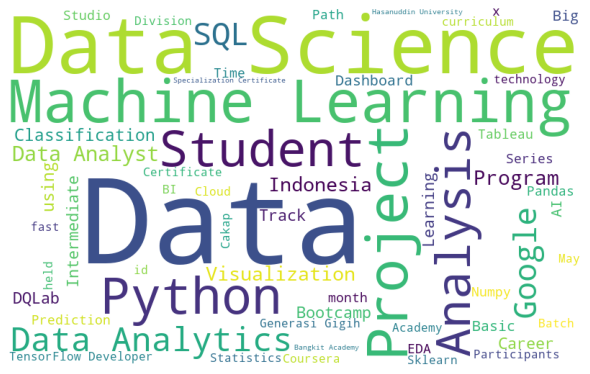

In [ ]:
#Create and generate a word cloud image for the best candidate for Senior Data Engineer
wordcloud = WordCloud(width = 800, height = 500,background_color ='white', min_font_size = 10).generate(resumeTxt[13])
# Display the generated image
plt.figure(figsize = (20,5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

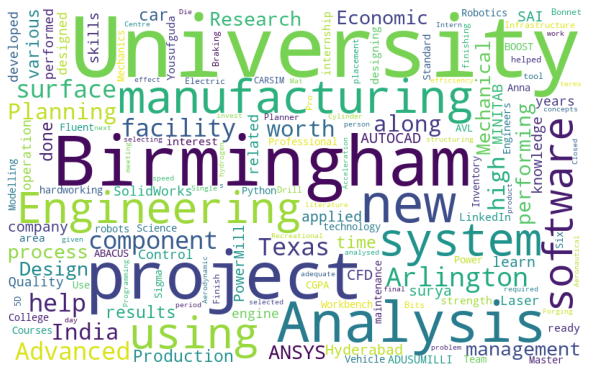

In [ ]:
#Create and generate a word cloud image for the best candidate for Control System Engineer
wordcloud = WordCloud(width = 800, height = 500,background_color ='white', min_font_size = 10).generate(resumeTxt[28])
# Display the generated image
plt.figure(figsize = (20,5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

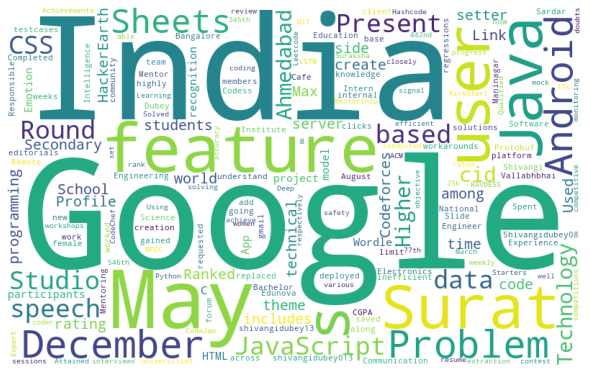

In [ ]:
#Create and generate a word cloud image for the best candidate for Software Engineer
wordcloud = WordCloud(width = 800, height = 500,background_color ='white', min_font_size = 10).generate(resumeTxt[6])
# Display the generated image
plt.figure(figsize = (20,5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

###Conclusion :    
We implemented a basic version of the AI-based resume screening and shortlisting
model and got a sensible output.